# VLB Bell Model — Shear-Thinning Flow Curves

**Force-dependent bond breakage (Bell model) in VLB transient networks**

## Context: Force-Enhanced Detachment

The **Bell model** extends VLB by making bond breakage rate force-dependent:

$$k_d(\boldsymbol{\mu}) = k_{d,0} \exp\left[\nu \left(\lambda_c - 1\right)\right]$$

where $\lambda_c = \sqrt{\text{tr}(\boldsymbol{\mu})/3}$ is the characteristic chain stretch and $\nu$ is the force sensitivity. Physical picture: chains under tension break faster due to reduced activation barrier (Bell-Evans theory).

**Key consequences:**
- **Shear thinning**: Viscosity decreases with shear rate (constant $k_d$ gives Newtonian)
- **Stress overshoot**: Startup transients show peak at high Wi (not possible with constant $k_d$)
- **LAOS nonlinearity**: $I_3/I_1 > 0$ (shear stress has higher harmonics)
- **S-shaped flow curve**: Can trigger shear banding (Notebook 10)

Materials: Cytoskeletal networks (actin-binding proteins), supramolecular polymers (labile hydrogen bonds), microgels (compression-sensitive cross-links).

> **Handbook:** See [VLB Variant Reference](../../docs/source/models/vlb/vlb_variant.rst) for Bell kinetics derivation, [VLB Knowledge](../../docs/source/models/vlb/vlb_knowledge.rst) for shear-thinning diagnostics.

## Learning Objectives

- Understand force-dependent bond breakage (Bell model)
- Observe shear thinning from Bell vs Newtonian from constant $k_d$
- See stress overshoot in startup shear at high Weissenberg numbers
- Observe nonlinear LAOS harmonics ($I_3/I_1 > 0$)

## Prerequisites

- VLB fundamentals (notebooks 01, 05)
- Flow curve concepts (notebook 01)

## Estimated Runtime

- ~2-3 min (ODE integration required for Bell breakage)

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal, VLBVariant

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: Bell Breakage Model

The **Bell model** makes bond breakage rate force-dependent:

$$k_d(\boldsymbol{\mu}) = k_{d,0} \exp\left[\nu \left(\lambda_c - 1\right)\right]$$

where:
- $\lambda_c = \sqrt{\text{tr}(\boldsymbol{\mu})/3}$ is the characteristic stretch
- $\nu$ is the **force sensitivity** parameter
- When $\nu = 0$, recovers constant $k_d = k_{d,0}$ (Newtonian)

**Physical interpretation:**
- Stretched chains ($\lambda_c > 1$) break faster
- Higher $\nu$ → stronger force-sensitivity → more shear thinning
- At high shear rates, increased breakage lowers viscosity

**Flow curve prediction:**
- $\nu = 0$: Linear $\sigma = \eta_0 \dot{\gamma}$ (Newtonian)
- $\nu > 0$: Shear-thinning $\sigma \sim \dot{\gamma}^n$ with $n < 1$

**Key relations:**
- Relaxation time: $t_R = 1/k_d(\lambda_c)$ (state-dependent)
- Weissenberg number: $Wi = \dot{\gamma} \cdot t_R$
- Shear thinning emerges when $Wi > 1$

## 3. Shear-Thinning Flow Curve

Compare constant vs Bell breakage to see the emergence of shear thinning.

In [3]:
# Constant breakage (Newtonian baseline)
model_const = VLBVariant(breakage="constant")
model_const.parameters.set_value("G0", 1000.0)
model_const.parameters.set_value("k_d_0", 1.0)
model_const.parameters.set_value("eta_s", 0.0)

# Bell breakage (shear thinning)
model_bell = VLBVariant(breakage="bell")
model_bell.parameters.set_value("G0", 1000.0)
model_bell.parameters.set_value("k_d_0", 1.0)
model_bell.parameters.set_value("nu", 5.0)
model_bell.parameters.set_value("eta_s", 0.0)

print("Constant breakage (Newtonian):")
print(f"  G₀ = {model_const.G0:.1f} Pa")
print(f"  k_d = {model_const.k_d_0:.2f} 1/s")
print(f"  η₀ = {model_const.viscosity:.1f} Pa·s")
print(f"\nBell breakage (shear-thinning):")
print(f"  G₀ = {model_bell.G0:.1f} Pa")
print(f"  k_d₀ = {model_bell.k_d_0:.2f} 1/s")
print(f"  ν = {model_bell.nu:.1f}")
print(f"  η₀ = {model_bell.viscosity:.1f} Pa·s (low-shear limit)")

Constant breakage (Newtonian):
  G₀ = 1000.0 Pa
  k_d = 1.00 1/s
  η₀ = 1000.0 Pa·s

Bell breakage (shear-thinning):
  G₀ = 1000.0 Pa
  k_d₀ = 1.00 1/s
  ν = 5.0
  η₀ = 1000.0 Pa·s (low-shear limit)


In [4]:
# Predict flow curves
gamma_dot = np.logspace(-2, 2, 40)

import time

t0 = time.time()
sigma_const, eta_const = model_const.predict_flow_curve(gamma_dot)
t_const = time.time() - t0

t0 = time.time()
sigma_bell, eta_bell = model_bell.predict_flow_curve(gamma_dot)
t_bell = time.time() - t0

print(f"Constant: {t_const:.2f} s")
print(f"Bell: {t_bell:.2f} s")

Constant: 1.09 s
Bell: 0.79 s


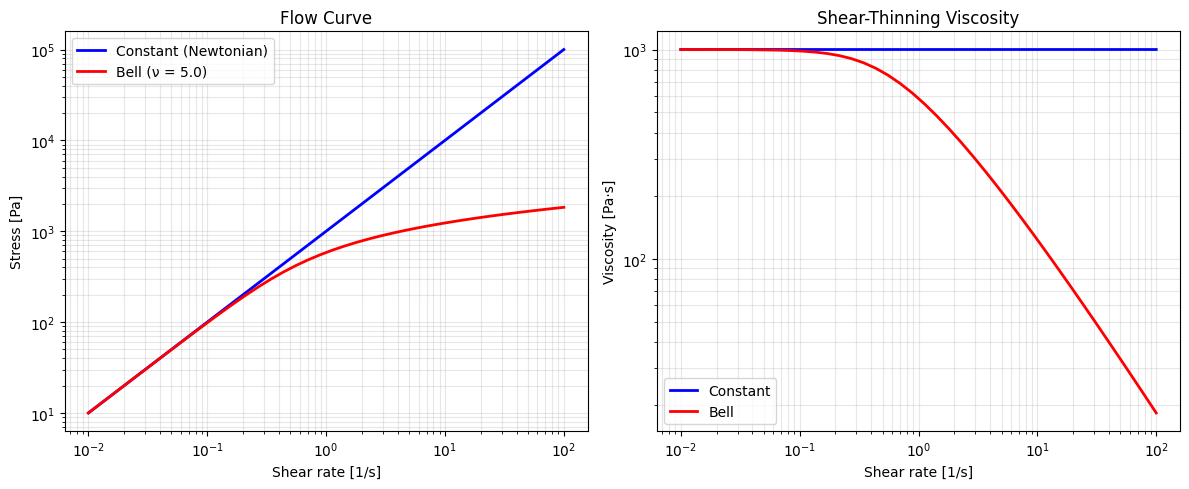


Viscosity ratio (high/low shear):
  Constant: 1.00 (flat = Newtonian)
  Bell: 0.02 (< 1 = shear-thinning)


In [5]:
# Plot flow curves and viscosity (sigma and eta already unpacked above)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Flow curve
ax1.loglog(gamma_dot, sigma_const, "b-", lw=2, label="Constant (Newtonian)")
ax1.loglog(gamma_dot, sigma_bell, "r-", lw=2, label=f"Bell (ν = {model_bell.nu:.1f})")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Flow Curve")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Viscosity
ax2.loglog(gamma_dot, eta_const, "b-", lw=2, label="Constant")
ax2.loglog(gamma_dot, eta_bell, "r-", lw=2, label="Bell")
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Viscosity [Pa·s]")
ax2.set_title("Shear-Thinning Viscosity")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nViscosity ratio (high/low shear):")
print(f"  Constant: {eta_const[-1]/eta_const[0]:.2f} (flat = Newtonian)")
print(f"  Bell: {eta_bell[-1]/eta_bell[0]:.2f} (< 1 = shear-thinning)")

## 4. Effect of Force Sensitivity (nu)

Vary $\nu$ to see how force sensitivity controls shear-thinning strength.

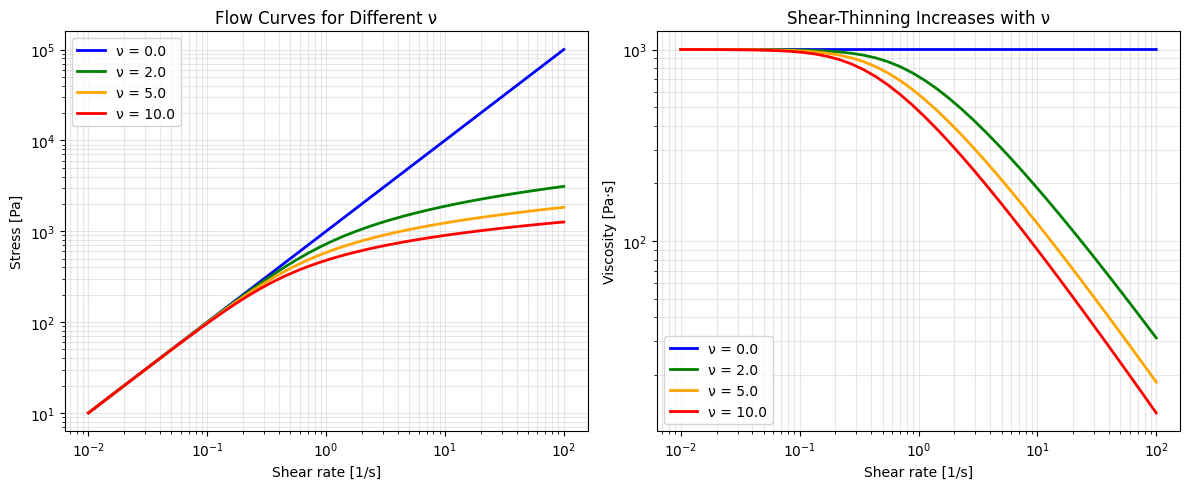

As ν increases:
  - Shear-thinning becomes stronger
  - Viscosity decreases more rapidly at high shear rates
  - Stress plateau at high shear rates becomes more pronounced


In [6]:
nu_values = [0.0, 2.0, 5.0, 10.0]
colors = ["blue", "green", "orange", "red"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for nu_val, color in zip(nu_values, colors):
    if nu_val == 0.0:
        # Use constant breakage for nu = 0
        model = VLBVariant(breakage="constant")
        model.parameters.set_value("G0", 1000.0)
        model.parameters.set_value("k_d_0", 1.0)
    else:
        model = VLBVariant(breakage="bell")
        model.parameters.set_value("G0", 1000.0)
        model.parameters.set_value("k_d_0", 1.0)
        model.parameters.set_value("nu", nu_val)
    
    sigma, eta = model.predict_flow_curve(gamma_dot)
    
    ax1.loglog(gamma_dot, sigma, color=color, lw=2, label=f"ν = {nu_val:.1f}")
    ax2.loglog(gamma_dot, eta, color=color, lw=2, label=f"ν = {nu_val:.1f}")

ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Flow Curves for Different ν")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Viscosity [Pa·s]")
ax2.set_title("Shear-Thinning Increases with ν")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

print("As ν increases:")
print("  - Shear-thinning becomes stronger")
print("  - Viscosity decreases more rapidly at high shear rates")
print("  - Stress plateau at high shear rates becomes more pronounced")

## 5. Stress Overshoot in Startup Shear

At high Weissenberg numbers (Wi = γ̇/k_d > 1), transient stress overshoot appears.

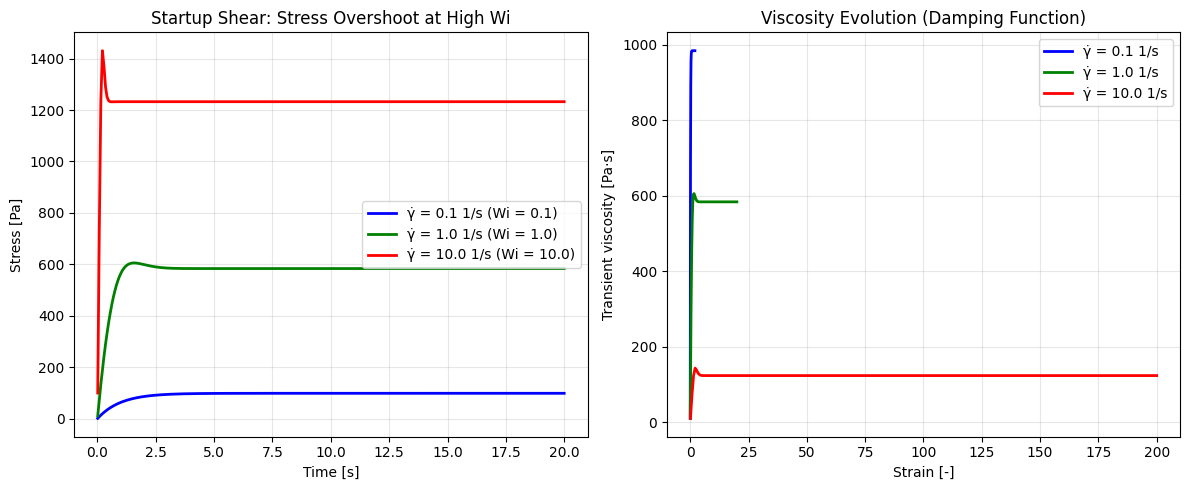

Key observations:
  - Low Wi (0.1): No overshoot, linear stress growth
  - Medium Wi (1): Small overshoot
  - High Wi (10): Strong overshoot, then relaxation to steady state

Overshoot mechanism: Fast stretching → high stress → accelerated breakage → stress decay


In [7]:
# Use Bell model with nu = 5
model_bell = VLBVariant(breakage="bell")
model_bell.parameters.set_value("G0", 1000.0)
model_bell.parameters.set_value("k_d_0", 1.0)
model_bell.parameters.set_value("nu", 5.0)

t = np.linspace(0.01, 20, 300)
gamma_dot_values = [0.1, 1.0, 10.0]
colors = ["blue", "green", "red"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for gd, color in zip(gamma_dot_values, colors):
    sigma_t = model_bell.simulate_startup(t, gamma_dot=gd)
    wi = model_bell.weissenberg_number(gd)
    
    ax1.plot(t, sigma_t, color=color, lw=2, label=f"γ̇ = {gd:.1f} 1/s (Wi = {wi:.1f})")
    ax2.plot(t * gd, np.array(sigma_t) / gd, color=color, lw=2, label=f"γ̇ = {gd:.1f} 1/s")

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Startup Shear: Stress Overshoot at High Wi")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Strain [-]")
ax2.set_ylabel("Transient viscosity [Pa·s]")
ax2.set_title("Viscosity Evolution (Damping Function)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Key observations:")
print("  - Low Wi (0.1): No overshoot, linear stress growth")
print("  - Medium Wi (1): Small overshoot")
print("  - High Wi (10): Strong overshoot, then relaxation to steady state")
print("\nOvershoot mechanism: Fast stretching → high stress → accelerated breakage → stress decay")

## 6. LAOS Harmonics

Compare constant (purely linear) vs Bell (nonlinear) under Large Amplitude Oscillatory Shear.

In [8]:
# Simulate LAOS
t_laos = np.linspace(0.01, 60, 2000)
gamma_0 = 1.0
omega = 1.0

model_const = VLBVariant(breakage="constant")
model_const.parameters.set_value("G0", 1000.0)
model_const.parameters.set_value("k_d_0", 1.0)

model_bell = VLBVariant(breakage="bell")
model_bell.parameters.set_value("G0", 1000.0)
model_bell.parameters.set_value("k_d_0", 1.0)
model_bell.parameters.set_value("nu", 5.0)

result_const = model_const.simulate_laos(t_laos, gamma_0=gamma_0, omega=omega)
result_bell = model_bell.simulate_laos(t_laos, gamma_0=gamma_0, omega=omega)

print(f"LAOS parameters:")
print(f"  γ₀ = {gamma_0}")
print(f"  ω = {omega} rad/s")
print(f"  De (Bell) = {model_bell.deborah_number(omega):.2f}")

LAOS parameters:
  γ₀ = 1.0
  ω = 1.0 rad/s
  De (Bell) = 1.00


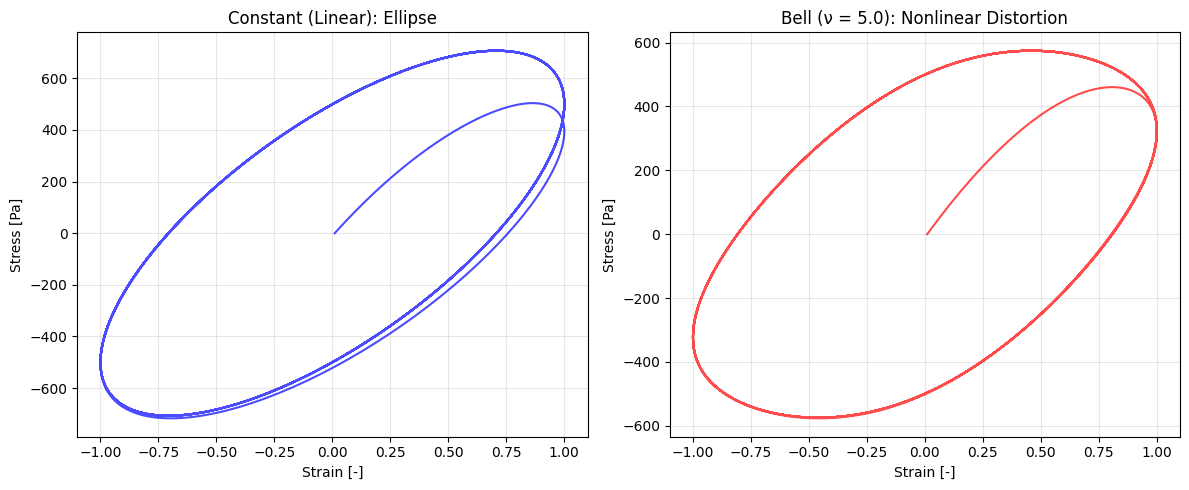

In [9]:
# Extract harmonics
harmonics_const = model_const.extract_laos_harmonics(result_const, n_harmonics=5)
harmonics_bell = model_bell.extract_laos_harmonics(result_bell, n_harmonics=5)

# Plot Lissajous curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Constant (linear)
ax1.plot(result_const["strain"], result_const["stress"], "b-", lw=1.5, alpha=0.7)
ax1.set_xlabel("Strain [-]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Constant (Linear): Ellipse")
ax1.grid(True, alpha=0.3)

# Bell (nonlinear)
ax2.plot(result_bell["strain"], result_bell["stress"], "r-", lw=1.5, alpha=0.7)
ax2.set_xlabel("Strain [-]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title(f"Bell (ν = {model_bell.nu:.1f}): Nonlinear Distortion")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

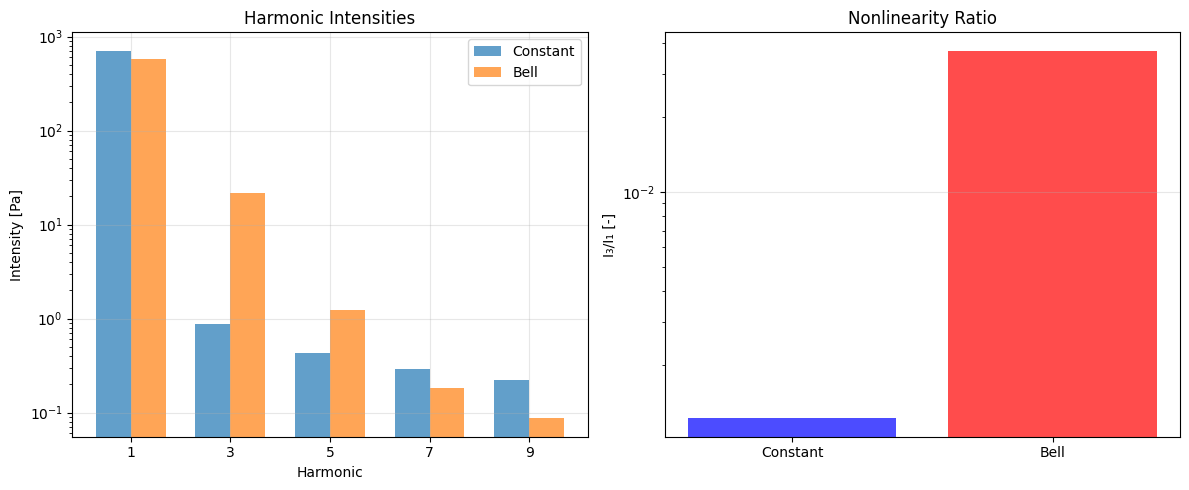


Nonlinearity analysis:
  Constant I₃/I₁ = 0.001224 (machine precision, linear)
  Bell I₃/I₁ = 0.0371 (> 1e-3 indicates nonlinearity)

  Bell model shows 30x stronger third harmonic


In [10]:
# Compare harmonic intensities using the harmonics array
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Magnitude spectrum — harmonics_const["harmonics"] is [I1, I3, I5, ...]
h_const = harmonics_const["harmonics"]
h_bell = harmonics_bell["harmonics"]
n_harm = min(5, len(h_const), len(h_bell))
harmonic_indices = [2 * i + 1 for i in range(n_harm)]  # 1, 3, 5, 7, 9

x = np.arange(n_harm)
width = 0.35

ax1.bar(x - width/2, h_const[:n_harm], width, label="Constant", alpha=0.7)
ax1.bar(x + width/2, h_bell[:n_harm], width, label="Bell", alpha=0.7)
ax1.set_xlabel("Harmonic")
ax1.set_ylabel("Intensity [Pa]")
ax1.set_title("Harmonic Intensities")
ax1.set_xticks(x)
ax1.set_xticklabels([f"{i}" for i in harmonic_indices])
ax1.legend()
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)

# Nonlinearity ratio I3/I1
ratio_const = harmonics_const["I3_I1"]
ratio_bell = harmonics_bell["I3_I1"]

ax2.bar(["Constant", "Bell"], [max(ratio_const, 1e-15), ratio_bell],
        color=["blue", "red"], alpha=0.7)
ax2.set_ylabel("I₃/I₁ [-]")
ax2.set_title("Nonlinearity Ratio")
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nNonlinearity analysis:")
print(f"  Constant I₃/I₁ = {ratio_const:.6f} (machine precision, linear)")
print(f"  Bell I₃/I₁ = {ratio_bell:.4f} (> 1e-3 indicates nonlinearity)")
if ratio_const > 0:
    print(f"\n  Bell model shows {ratio_bell/max(ratio_const, 1e-15):.0f}x stronger third harmonic")

## 7. Key Takeaways

1. **Bell breakage introduces shear thinning** — Force-dependent k_d leads to non-Newtonian flow
2. **Force sensitivity (nu) controls thinning strength** — Higher ν → stronger shear thinning
3. **Stress overshoot at high Wi** — Fast stretching → high stress → accelerated breakage → decay
4. **LAOS nonlinearity** — Bell model produces odd harmonics (I₃, I₅), constant does not
5. **VLBVariant with constant breakage** — Exactly recovers VLBLocal (Newtonian)

## Physical Interpretation

The Bell model captures how mechanical force accelerates bond dissociation:
- Low shear: Minimal stretching, k_d ≈ k_d,0 (Newtonian plateau)
- High shear: Strong stretching, k_d >> k_d,0 (shear thinning)
- Startup: Transient overstretching before reaching steady state
- LAOS: Strain-dependent k_d during oscillation → nonlinear response

## Next Steps

- **FENE stress**: See notebook for finite extensibility effects
- **Temperature dependence**: Arrhenius k_d(T) for thermal rheology
- **Combined effects**: Bell + FENE for realistic polymer melts

## 8. Save Results

In [11]:
import json
import os

output_dir = os.path.join("..", "outputs", "vlb", "bell")
os.makedirs(output_dir, exist_ok=True)

# Save Bell model parameters
params_bell = {
    "G0": float(model_bell.G0),
    "k_d_0": float(model_bell.k_d_0),
    "nu": float(model_bell.nu),
    "eta_0": float(model_bell.viscosity),
    "relaxation_time": float(model_bell.relaxation_time)
}

with open(os.path.join(output_dir, "bell_params.json"), "w") as f:
    json.dump(params_bell, f, indent=2)

# Save LAOS harmonics
laos_results = {
    "constant": {
        "I3_I1_ratio": float(ratio_const)
    },
    "bell": {
        "I3_I1_ratio": float(ratio_bell)
    }
}

with open(os.path.join(output_dir, "laos_harmonics.json"), "w") as f:
    json.dump(laos_results, f, indent=2)

print(f"Saved to {output_dir}/")
print(f"  - bell_params.json")
print(f"  - laos_harmonics.json")

Saved to ../outputs/vlb/bell/
  - bell_params.json
  - laos_harmonics.json
